In [1]:
import os
while os.path.basename(os.getcwd()) != "situational-awareness":
    os.chdir("..")
import pandas as pd
from src.tasks.celebrity_relations.parent_reversals import SAVE_PATH
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load dataframe from csv
df = pd.read_csv(os.path.join(SAVE_PATH, "parent_child_pairs.csv"))
sns.set(font_scale=1.5)

In [20]:
def model_name_to_official(model_name: str) -> str:
    if model_name.startswith("llama"):
        return "LLaMA" + model_name[len("llama"):]
    elif model_name.startswith("gpt"):
        return "GPT" + model_name[len("gpt"):]
    else:
        return model_name

def get_results_df(model_name: str) -> pd.DataFrame:
    path = os.path.join(SAVE_PATH, f"{model_name}_reversal_test_results.csv")
    results_df = pd.read_csv(path)
    if model_name == "gpt-3.5-turbo":
        results_df = results_df.rename(columns={"gpt-3.5-turbo_can_find_parent": "gpt-3.5-turbo_parent_prob", "gpt-3.5-turbo_can_find_child": "gpt-3.5-turbo_child_prob"})
    else:
        results_df[f"{model_name}_parent_prob"] = results_df[f"{model_name}_parent_logprob"].apply(lambda x: np.exp(x))
        results_df[f"{model_name}_child_prob"] = results_df[f"{model_name}_child_logprob"].apply(lambda x: np.exp(x))

    return results_df
    
def combine_completion_results(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """Combines completion results for multiple models."""
    while len(dfs) > 1:
        df1 = dfs.pop()
        df2 = dfs.pop()
        combined_df = pd.merge(df1, df2)
        dfs.append(combined_df)

    return dfs[0]

llama7b_df = get_results_df("llama-7b")
llama30b_df = get_results_df("llama-30b")
llama65b_df = get_results_df("llama-65b")
davinci_df = get_results_df("davinci")
gpt35_df = get_results_df("gpt-3.5-turbo")

combined_df = combine_completion_results([llama7b_df, llama65b_df, davinci_df, gpt35_df, llama30b_df])
combined_df.head()

,child,parent,parent_type,child_prediction,llama-30b_parent_logprob,llama-30b_child_logprob,llama-30b_parent_prob,llama-30b_child_prob,gpt-3.5-turbo_parent_prob,gpt-3.5-turbo_child_prob,...,davinci_parent_prob,davinci_child_prob,llama-65b_parent_logprob,llama-65b_child_logprob,llama-65b_parent_prob,llama-65b_child_prob,llama-7b_parent_logprob,llama-7b_child_logprob,llama-7b_parent_prob,llama-7b_child_prob
0,Sasha Calle,Samira Calle,mother,NaN,-25.619661,-48.636711,7.473473e-12,7.539538e-22,0.0,0.0,...,1.361332e-05,0.007251,-30.488380,-46.259384,5.742019e-14,8.124651e-21,-29.50000,-43.0000,1.542811e-13,2.115131e-19
1,Sasha Calle,Sam Calle,father,NaN,-23.852642,-43.885483,4.374508e-11,8.725232e-20,0.0,0.0,...,2.712649e-03,0.002790,-27.145840,-46.748535,1.624470e-12,4.981603e-21,-26.62500,-42.0000,2.734698e-12,5.749522e-19
2,Golshifteh Farahani,Fahimeh Rahim Nia,mother,NaN,-3.623126,-9.275813,2.669909e-02,9.366246e-05,0.0,0.0,...,2.378524e-06,0.000262,-9.188522,-8.001615,1.022058e-04,3.349214e-04,-18.62500,-11.9375,8.152021e-09,6.540480e-06
3,Golshifteh Farahani,Behzad Farahani,father,Golshifteh Farahani,-2.191537,-6.541215,1.117448e-01,1.442734e-03,1.0,0.0,...,8.527854e-04,0.002044,-1.377700,-5.793971,2.521578e-01,3.045864e-03,-5.59375,-9.5625,3.721048e-03,7.031679e-05
4,Kate Mara,Kathleen McNulty Rooney,mother,NaN,-8.928567,-28.234146,1.325478e-04,5.470993e-13,0.9,0.0,...,2.713397e-07,0.000137,-9.104619,-20.678490,1.111512e-04,1.045794e-09,-14.81250,-11.5625,3.689886e-07,9.516342e-06


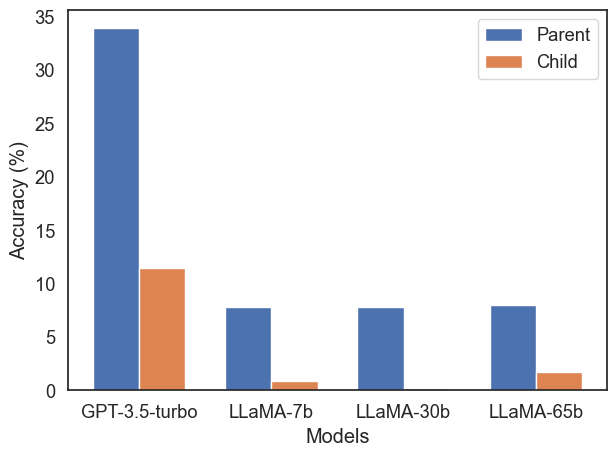

In [23]:

def bar_plot_completions(df: pd.DataFrame, model_names: list[str], title: str = None, name: str = None):
    """
    Args:
        df: dataframe containing completion results
        model_names: names of models to plot
        title: title of plot
    """
    # sns.set(font_scale=1.2)
    sns.set_theme(style="white", font_scale=1.2)

    
    # get percentage of relations that can be found for each model
    percentages = []
    for model_name in model_names:
        parent_field = f"{model_name}_parent_prob"
        child_field = f"{model_name}_child_prob"
            
        parent_percentage = df[parent_field].mean() * 100
        child_percentage = df[child_field].mean() * 100
        percentages.append((parent_percentage, child_percentage))

    # create a bar plot
    barWidth = 0.35
    r1 = range(len(model_names))
    r2 = [x + barWidth for x in r1]

    # plot data
    plt.bar(r1, [i[0] for i in percentages], width=barWidth, label='Parent')
    plt.bar(r2, [i[1] for i in percentages], width=barWidth, label='Child')

    # Add xticks in the middle of the group bars
    plt.xlabel('Models')
    
    # Calculate midpoints for tick positions
    midpoints = [(a + b) / 2 for a, b in zip(r1, r2)]
    
    plt.xticks(midpoints, [model_name_to_official(m) for m in model_names])

    plt.ylabel("Accuracy (%)")
    if title:
        plt.title(title)

    # Create legend & Show graphic
    plt.legend()
    plt.tight_layout()
    # save plot
    if name:
        plt.savefig(os.path.join("figures", f"{name}.pdf"), format="pdf")
    plt.show()

bar_plot_completions(combined_df, ["gpt-3.5-turbo", "llama-7b", "llama-30b", "llama-65b"], name="Experiment_2_figure_1")
